In [31]:
# default_exp data.finance.forecast1

In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from libs import is_lib_exists

In [35]:
required_libs = [ ("numpy", "numpy"),
                  ("pandas", "pandas"),
                  ("seaborn", "seaborn"),
                  ("matplotlib", "matplotlib"),
                  ("investpy", "investpy"),
                  ("dateutil", "python-dateutil"),
                  ("fbprophet", "fbprophet"),
                ]

In [36]:
for (clz,lib) in required_libs:
    if not is_lib_exists(clz):
        print(f"Installing {lib}")
        !pip install -qq {lib}
    else:
        print(f"{lib} exists")

numpy exists
pandas exists
seaborn exists
matplotlib exists
investpy exists
python-dateutil exists
fbprophet exists


In [95]:
#export
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import investpy
from pathlib import Path
from dateutil.relativedelta import *
from datetime import *
import calendar
import traceback
from ts_utils import *

In [96]:
%matplotlib inline

In [51]:
#%quickref
#%magic
#%env

In [40]:
from IPython.display import display, Image

# Finance Data

> Functionality to gather finance data.

The classes here provide bases classes used to gather finance data for model training.

In [42]:
#hide
from nbdev.showdoc import *

In [43]:
# Dataset path
DATASET_PATH = Path("../../data")  

# Country to analyze
COUNTRY = "malaysia"

# Dataset
DATASET = DATASET_PATH/f"ftse_klse_investing.csv"

# Stocks summary
DATASET_STOCKS_SUMMARY = DATASET_PATH/f"stocks_summary.csv"

## FTSE KLSE

In [303]:
# Retrieve stock components
dataset = investpy.get_stocks(country=COUNTRY)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    929 non-null    object
 1   name       929 non-null    object
 2   full_name  929 non-null    object
 3   isin       929 non-null    object
 4   currency   929 non-null    object
 5   symbol     929 non-null    object
dtypes: object(6)
memory usage: 43.7+ KB


In [304]:
# Save the dataset
dataset.to_csv(DATASET, index=False)

# dataset = pd.read_csv(DATASET, header=0, sep=',', quotechar='"')

In [340]:
print(f"Number of stock - {len(dataset)}")
display(dataset.head(3))

Number of stock - 929


,country,name,full_name,isin,currency,symbol
0,malaysia,Media Chinese Int,Media Chinese International Ltd,BMG5959D1048,MYR,MDCH
1,malaysia,AMMB,AMMB Holdings Bhd,MYL1015OO006,MYR,AMMB
2,malaysia,CIMB Group,CIMB Group Holdings Bhd,MYL1023OO000,MYR,CIMB


In [341]:
FROM_DATE = '1/3/2019'

TO_DATE = datetime.strftime(date.today(), '%d/%m/%Y')
#TO_DATE="30/9/2020"

TEST_DATE = "2020-10-01"

TEST_STOCK_CODE="MBBM"

print(FROM_DATE, TO_DATE)

1/3/2019 15/10/2020


In [342]:
df = investpy.get_stock_historical_data(stock=TEST_STOCK_CODE,
                                        country=COUNTRY,
                                        from_date=FROM_DATE,
                                        to_date=TO_DATE)
df.reset_index(inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume,Currency
397,2020-10-09,7.26,7.40,7.20,7.40,4985700,MYR
398,2020-10-12,7.37,7.38,7.24,7.35,3319800,MYR
399,2020-10-13,7.30,7.39,7.25,7.35,2762900,MYR
400,2020-10-14,7.35,7.35,7.24,7.24,5637500,MYR
401,2020-10-15,7.24,7.27,7.20,7.21,3248000,MYR


In [343]:
ts = df[['Date','Close']].copy()
ts.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
ts.set_index(['ds'], inplace=True)
ts = ts['y']
ts.name = TEST_STOCK_CODE
ts

ds
2019-03-01    9.53
2019-03-04    9.54
2019-03-05    9.53
2019-03-06    9.54
2019-03-07    9.53
              ... 
2020-10-09    7.40
2020-10-12    7.35
2020-10-13    7.35
2020-10-14    7.24
2020-10-15    7.21
Name: MBBM, Length: 402, dtype: float64

In [344]:
print("population --> len:", len(ts), "| mean:", round(ts.mean()), " | std:", round(ts.std()))
w = 30
print("moving --> len:", w, " | mean:", round(ts.ewm(span=w).mean()[-1]), " | std:", round(ts.ewm(span=w).std()[-1]))

population --> len: 402 | mean: 8  | std: 1
moving --> len: 30  | mean: 7  | std: 0


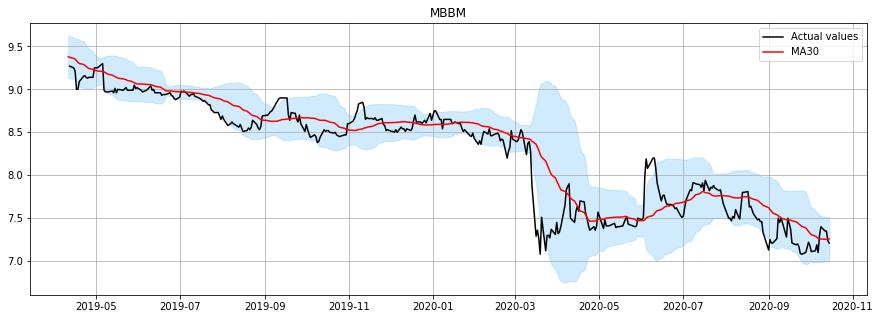

In [345]:
plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

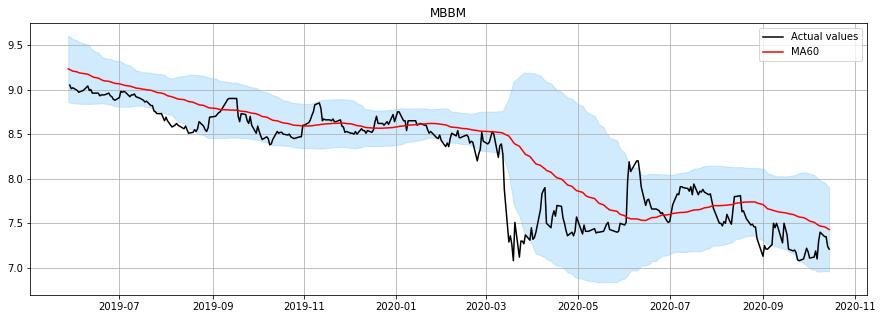

In [346]:
# looks like a soft downtrend, it should be clear with a window of 1 year
plot_ts(ts, plot_ma=True, plot_intervals=True, window=60, figsize=(15,5))

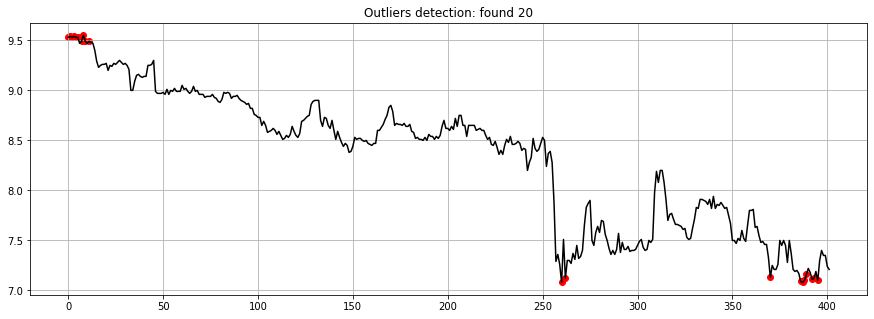

In [347]:
# outliers
dtf_outliers = find_outliers(ts, perc=0.05, figsize=(15,5))

In [348]:
# Remove outliers?
# ts_clean = remove_outliers(ts, outliers_idx=dtf_outliers[dtf_outliers["outlier"]==1].index, figsize=(15,5))

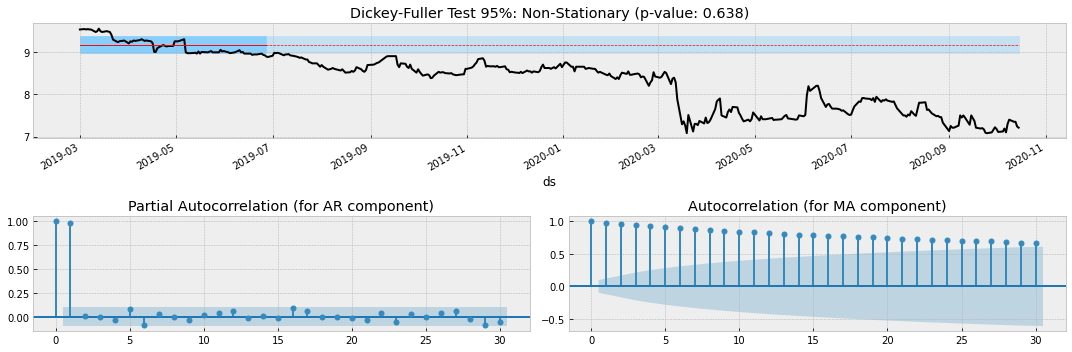

In [349]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=w, figsize=(15,5))

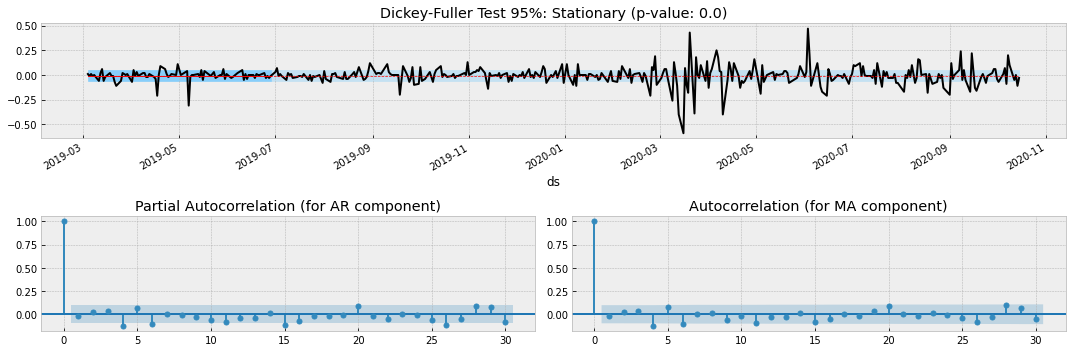

In [350]:
# try with differentiating ts
test_stationarity_acf_pacf(diff_ts(ts, order=1), sample=0.20, maxlag=30, figsize=(15,5))

/Users/mengwangk/workspace/development/investor/investor/experiment/science/nbdev/nbs/ts_utils.py:138: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



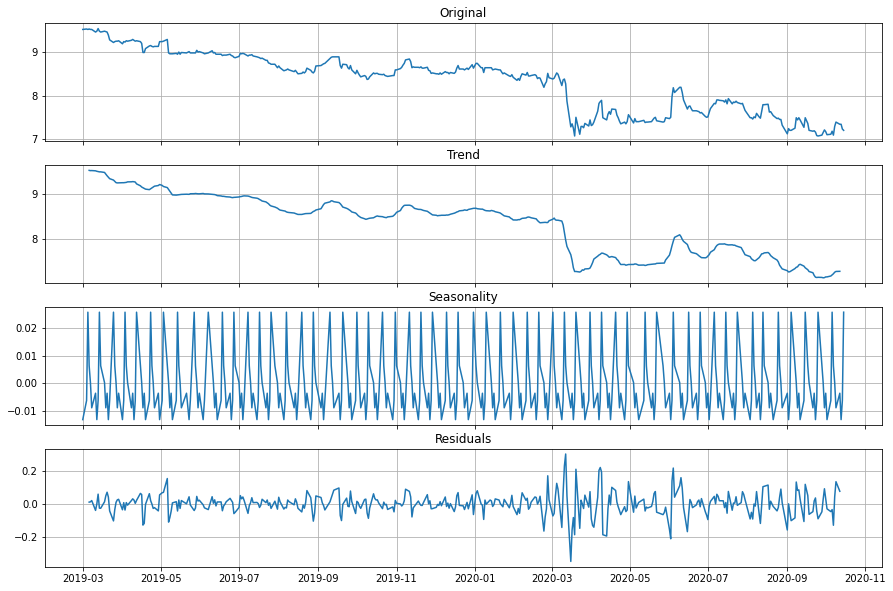

In [351]:
# seasonality
dic_decomposed = decompose_ts(ts, s=7, figsize=(15,10))

--- splitting at index:  391 | 2020-10-01 00:00:00 | test size: 0.03  ---


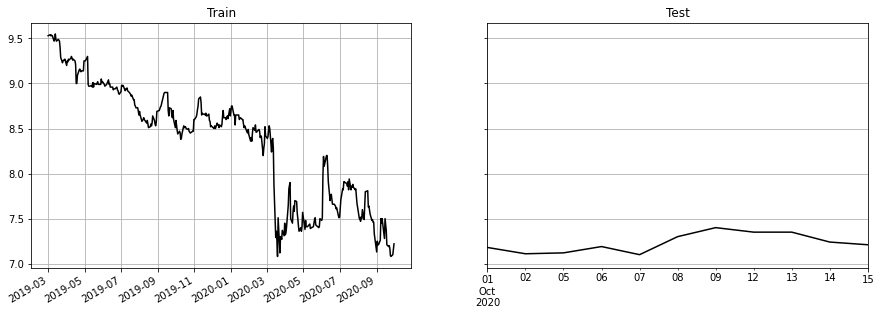

(391, 11)

In [352]:
# Pre-processing
ts_train, ts_test = split_train_test(ts, exog=None, test=TEST_DATE, plot=True, figsize=(15,5))
len(ts_train), len(ts_test)

In [353]:
dtf_train = ts_train.reset_index().rename(columns={TEST_STOCK_CODE:'y'})
dtf_test = ts_test.reset_index().rename(columns={TEST_STOCK_CODE:'y'})

dtf_train.tail()

,ds,y
386,2020-09-24,7.09
387,2020-09-25,7.08
388,2020-09-28,7.10
389,2020-09-29,7.16
390,2020-09-30,7.22


In [354]:
dtf_holidays = None

In [355]:
model = Prophet()
#model = Prophet(daily_seasonality=True, yearly_seasonality=False)
#model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
#                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
#                holidays=dtf_holidays, interval_width=0.80)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


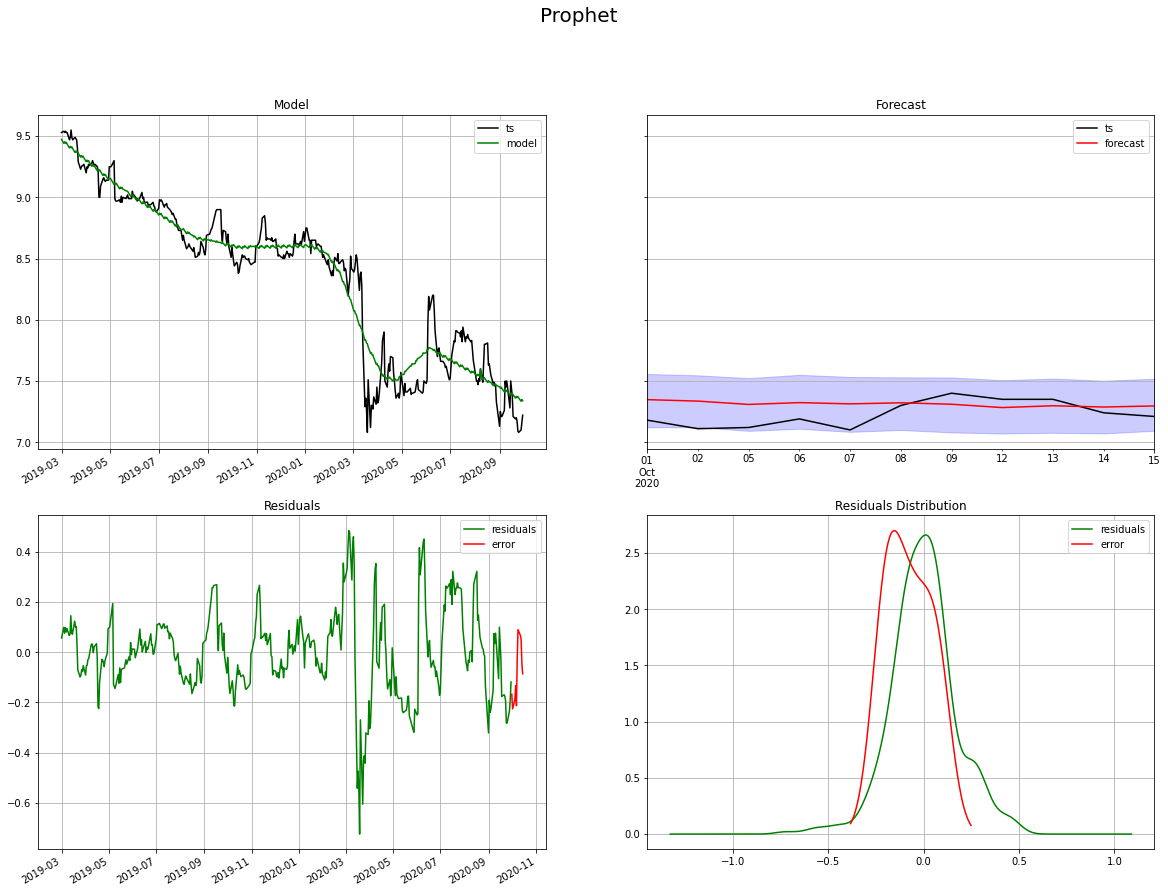

Training --> Residuals mean: 0.0  | std: 0.0
Test --> Error mean: -0.0  | std: 0.0  | mae: 0.0  | mape: 2.0 %  | mse: 0.0  | rmse: 0.0


In [356]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, freq="D", figsize=(20,15))

In [357]:
# forecast
dtf = ts.reset_index().rename(columns={"date":"ds", TEST_STOCK_CODE:"y"})
dtf.tail()

,ds,y
397,2020-10-09,7.40
398,2020-10-12,7.35
399,2020-10-13,7.35
400,2020-10-14,7.24
401,2020-10-15,7.21


In [361]:
model = Prophet()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--- generating index date --> start: 2020-10-16 00:00:00 | end: 2020-12-31 00:00:00 | len: 77 ---


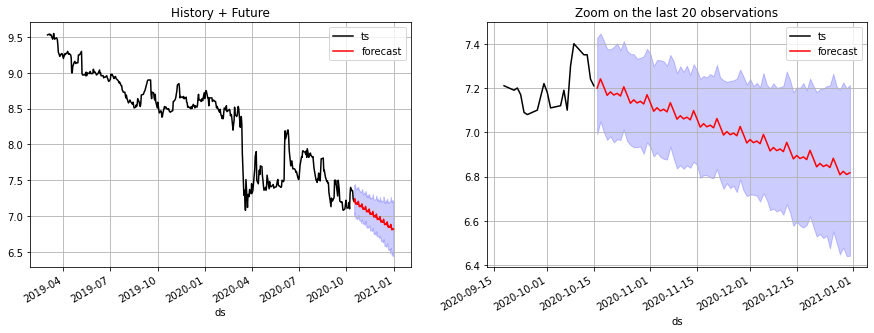

In [362]:
future = forecast_prophet(dtf, model, end="2020-12-31", freq="D", zoom=20, figsize=(15,5))

In [363]:
ts.min()

7.08

## Quick test

In [364]:
df = ts.reset_index().rename(columns={"date":"ds", TEST_STOCK_CODE:"y"})
df

,ds,y
0,2019-03-01,9.53
1,2019-03-04,9.54
2,2019-03-05,9.53
3,2019-03-06,9.54
4,2019-03-07,9.53
...,...,...
397,2020-10-09,7.40
398,2020-10-12,7.35
399,2020-10-13,7.35
400,2020-10-14,7.24


In [365]:
df_train = df[df['ds'] < TEST_DATE]
df_test = df[df['ds'] >= TEST_DATE]
df_test.tail()

,ds,y
397,2020-10-09,7.40
398,2020-10-12,7.35
399,2020-10-13,7.35
400,2020-10-14,7.24
401,2020-10-15,7.21


In [366]:
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [367]:
future = df_test.drop(columns=['y'])
future

,ds
391,2020-10-01
392,2020-10-02
393,2020-10-05
394,2020-10-06
395,2020-10-07
396,2020-10-08
397,2020-10-09
398,2020-10-12
399,2020-10-13
400,2020-10-14


In [368]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6,2020-10-09,7.309939,7.091336,7.523500
7,2020-10-12,7.282654,7.055562,7.493779
8,2020-10-13,7.297588,7.056381,7.517766
9,2020-10-14,7.287263,7.051968,7.512398
10,2020-10-15,7.296109,7.082246,7.504047


In [376]:
# for next 60 days
future = m.make_future_dataframe(periods=120)
future.tail()

,ds
506,2021-01-24
507,2021-01-25
508,2021-01-26
509,2021-01-27
510,2021-01-28


In [377]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(70)

,ds,yhat,yhat_lower,yhat_upper
441,2020-11-20,7.156135,6.891089,7.444028
442,2020-11-21,7.214088,6.943961,7.494445
443,2020-11-22,7.171022,6.908535,7.463303
444,2020-11-23,7.128850,6.833074,7.408804
445,2020-11-24,7.143784,6.862173,7.441473
...,...,...,...,...
506,2021-01-24,6.940317,6.347854,7.573853
507,2021-01-25,6.898145,6.280925,7.509597
508,2021-01-26,6.913078,6.297603,7.555264
509,2021-01-27,6.902754,6.287394,7.564318


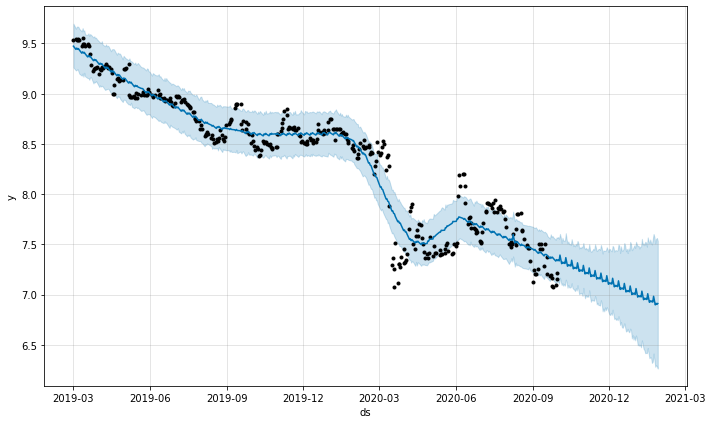

In [378]:
# Python
fig1 = m.plot(forecast)

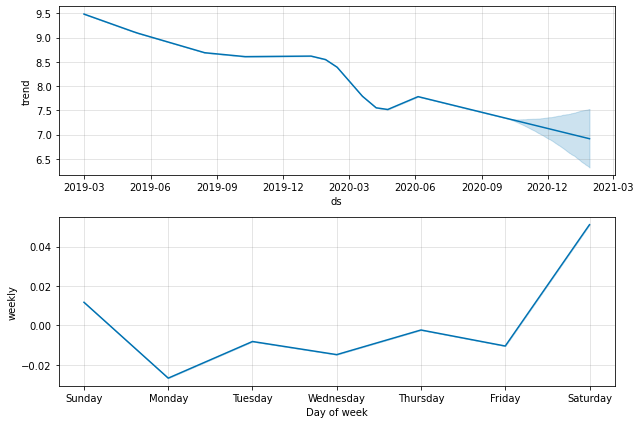

In [379]:
fig2 = m.plot_components(forecast)

In [380]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [381]:
plot_components_plotly(m, forecast)

In [375]:
# https://www.kaggle.com/manovirat/timeseries-using-prophet-hyperparameter-tuning
# https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
# https://medium.com/@Psr1/visual-parameter-tuning-with-facebook-prophet-and-python-8f50719c7318